In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [62]:
train_df = pd.read_csv("./transactions_train.csv")
articles = pd.read_csv("./articles.csv")

In [75]:
train_df.t_dat = pd.to_datetime(train_df.t_dat)

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


### Aggregation

In [4]:
%%time
transaction_matrix = train_df.groupby(["customer_id", "article_id"]).price.agg(["size", "mean", "median", "max", "min"])

CPU times: user 17.5 s, sys: 3.59 s, total: 21.1 s
Wall time: 21.7 s


In [5]:
transaction_matrix = transaction_matrix.rename(columns = {
    "size":"buy_count",
    "mean":"price_mean",
    "median":"price_median",
    "max":"price_max",
    "min":"price_min"
})
transaction_matrix = transaction_matrix.reset_index() 

### ID Mapping

In [6]:
uid_to_idx = {uid: idx for (idx, uid) in enumerate(transaction_matrix.customer_id.unique().tolist())}
iid_to_idx = {iid: idx for (idx, iid) in enumerate(transaction_matrix.article_id.unique().tolist())}

idx_to_iid = {idx:iid for iid, idx in iid_to_idx.items()}
idx_to_uid = {idx:uid for uid, idx in uid_to_idx.items()}

In [7]:
transaction_matrix = transaction_matrix.assign(
    user_id = transaction_matrix.customer_id.map(uid_to_idx),
    item_id = transaction_matrix.article_id.map(iid_to_idx)
)

transaction_matrix = transaction_matrix.drop(["customer_id", "article_id"], axis=1)

In [9]:
transaction_matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27306439 entries, 0 to 27306438
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   buy_count     int64  
 1   price_mean    float64
 2   price_median  float64
 3   price_max     float64
 4   price_min     float64
 5   user_id       int64  
 6   item_id       int64  
dtypes: float64(4), int64(3)
memory usage: 1.4 GB


### Simple most popular

In [16]:
%%time
popularity_simple = transaction_matrix.groupby("item_id").buy_count.sum()
popularity_user_count = transaction_matrix.groupby("item_id").size()
popularity_price = transaction_matrix.groupby("item_id").apply(lambda g: (g.price_mean * g.buy_count).sum()) ## bad code

CPU times: user 16.6 s, sys: 1.79 s, total: 18.4 s
Wall time: 19.1 s


In [17]:
popularity_simple_list = popularity_simple.nlargest(12).index.map(idx_to_iid).tolist()
popularity_user_count = popularity_user_count.nlargest(12).index.map(idx_to_iid).tolist()
popularity_price = popularity_price.nlargest(12).index.map(idx_to_iid).tolist()

In [92]:
articles = articles.set_index("article_id")

### Result

In [26]:
pd.options.display.max_columns=30

In [27]:
articles.loc[popularity_simple_list]

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,,,,,,,,,,,,
706016001,706016,Jade HW Skinny Denim TRS,272,Trousers,Garment Lower body,1010016,Solid,9,Black,4,Dark,5,Black,1747,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,High-waisted jeans in washed superstretch deni...
706016002,706016,Jade HW Skinny Denim TRS,272,Trousers,Garment Lower body,1010016,Solid,71,Light Blue,3,Light,2,Blue,1747,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,High-waisted jeans in washed superstretch deni...
372860001,372860,7p Basic Shaftless,302,Socks,Socks & Tights,1010016,Solid,9,Black,4,Dark,5,Black,3611,Shopbasket Socks,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,Fine-knit trainer socks in a soft cotton blend.
610776002,610776,Tilly (1),255,T-shirt,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,T-shirt in lightweight jersey with a rounded h...
759871002,759871,Tilda tank,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,3936,EQ Divided Basics,D,Divided,2,Divided,80,Divided Complements Other,1002,Jersey Basic,"Cropped, fitted top in cotton jersey with narr..."
464297007,464297,Greta Thong Mynta Low 3p,286,Underwear bottom,Underwear,1010014,Placement print,9,Black,4,Dark,5,Black,1334,Casual Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear",Thong briefs in cotton jersey with a wide lace...
372860002,372860,7p Basic Shaftless,302,Socks,Socks & Tights,1010016,Solid,10,White,3,Light,9,White,3611,Shopbasket Socks,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,Fine-knit trainer socks in a soft cotton blend.
610776001,610776,Tilly (1),255,T-shirt,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,T-shirt in lightweight jersey with a rounded h...
399223001,399223,Curvy Jeggings HW Ankle,272,Trousers,Garment Lower body,1010016,Solid,9,Black,4,Dark,5,Black,1772,Denim Trousers,D,Divided,2,Divided,57,Ladies Denim,1016,Trousers Denim,"Jeggings in washed, superstretch denim with a ..."


In [28]:
articles.loc[popularity_user_count]

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,,,,,,,,,,,,
706016001,706016,Jade HW Skinny Denim TRS,272,Trousers,Garment Lower body,1010016,Solid,9,Black,4,Dark,5,Black,1747,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,High-waisted jeans in washed superstretch deni...
372860001,372860,7p Basic Shaftless,302,Socks,Socks & Tights,1010016,Solid,9,Black,4,Dark,5,Black,3611,Shopbasket Socks,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,Fine-knit trainer socks in a soft cotton blend.
706016002,706016,Jade HW Skinny Denim TRS,272,Trousers,Garment Lower body,1010016,Solid,71,Light Blue,3,Light,2,Blue,1747,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,High-waisted jeans in washed superstretch deni...
610776002,610776,Tilly (1),255,T-shirt,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,T-shirt in lightweight jersey with a rounded h...
759871002,759871,Tilda tank,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,3936,EQ Divided Basics,D,Divided,2,Divided,80,Divided Complements Other,1002,Jersey Basic,"Cropped, fitted top in cotton jersey with narr..."
372860002,372860,7p Basic Shaftless,302,Socks,Socks & Tights,1010016,Solid,10,White,3,Light,9,White,3611,Shopbasket Socks,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,Fine-knit trainer socks in a soft cotton blend.
464297007,464297,Greta Thong Mynta Low 3p,286,Underwear bottom,Underwear,1010014,Placement print,9,Black,4,Dark,5,Black,1334,Casual Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear",Thong briefs in cotton jersey with a wide lace...
720125001,720125,SUPREME RW tights,273,Leggings/Tights,Garment Lower body,1010016,Solid,9,Black,4,Dark,5,Black,8310,Ladies Sport Bottoms,S,Sport,26,Sport,5,Ladies H&M Sport,1005,Jersey Fancy,Sports tights in fast-drying functional fabric...
673396002,673396,Ringo hipbelt,67,Belt,Accessories,1010016,Solid,9,Black,4,Dark,5,Black,3509,Belts,C,Ladies Accessories,1,Ladieswear,65,Womens Big accessories,1019,Accessories,Belt in grained imitation leather with a metal...


In [29]:
articles.loc[popularity_price]

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,,,,,,,,,,,,
706016001,706016,Jade HW Skinny Denim TRS,272,Trousers,Garment Lower body,1010016,Solid,9,Black,4,Dark,5,Black,1747,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,High-waisted jeans in washed superstretch deni...
706016002,706016,Jade HW Skinny Denim TRS,272,Trousers,Garment Lower body,1010016,Solid,71,Light Blue,3,Light,2,Blue,1747,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,High-waisted jeans in washed superstretch deni...
568601006,568601,Mariette Blazer,264,Blazer,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1212,Suit,A,Ladieswear,1,Ladieswear,11,Womens Tailoring,1008,Dressed,Fitted jacket in woven fabric with notch lapel...
448509014,448509,Perrie Slim Mom Denim TRS,272,Trousers,Garment Lower body,1010016,Solid,72,Blue,3,Light,2,Blue,1747,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,"5-pocket, ankle-length jeans in washed, sturdy..."
706016003,706016,Jade HW Skinny Denim TRS,272,Trousers,Garment Lower body,1010016,Solid,73,Dark Blue,2,Medium Dusty,2,Blue,1747,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,High-waisted jeans in washed superstretch deni...
399223001,399223,Curvy Jeggings HW Ankle,272,Trousers,Garment Lower body,1010016,Solid,9,Black,4,Dark,5,Black,1772,Denim Trousers,D,Divided,2,Divided,57,Ladies Denim,1016,Trousers Denim,"Jeggings in washed, superstretch denim with a ..."
720125001,720125,SUPREME RW tights,273,Leggings/Tights,Garment Lower body,1010016,Solid,9,Black,4,Dark,5,Black,8310,Ladies Sport Bottoms,S,Sport,26,Sport,5,Ladies H&M Sport,1005,Jersey Fancy,Sports tights in fast-drying functional fabric...
562245046,562245,Luna skinny RW,272,Trousers,Garment Lower body,1010016,Solid,9,Black,4,Dark,5,Black,1722,Trouser,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1009,Trousers,"5-pocket jeans in washed, superstretch denim w..."
751471001,751471,Pluto RW slacks (1),272,Trousers,Garment Lower body,1010016,Solid,9,Black,4,Dark,5,Black,1722,Trouser,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1009,Trousers,Ankle-length cigarette trousers in a stretch w...


### Submission

In [31]:
submission_sample = pd.read_csv("./sample_submission.csv")

In [36]:
customer_to_summit = set(submission_sample.customer_id)
customer_trained = set(uid_to_idx.keys())

In [48]:
print(f"제출할 유저 수: {len(customer_to_summit):,}")
print(f"데이터가 있는 유저 수: {len(customer_trained):,}")

print(f"데이터가 없는데 제출해야 하는 유저 수: {len(customer_to_summit - customer_trained):,}")
print(f"데이터가 있는데 제출하지 않는 유저 수: {len(customer_trained - customer_to_summit):,}")

제출할 유저 수: 1,371,980
데이터가 있는 유저 수: 1,362,281
데이터가 없는데 제출해야 하는 유저 수: 9,699
데이터가 있는데 제출하지 않는 유저 수: 0


In [49]:
submission_sample = submission_sample.drop("prediction", axis=1)

In [56]:
popularity_simple_str = " ".join([str(i) for i in popularity_simple_list])
submission_sample.assign(prediction=popularity_simple_str).to_csv("./submissions/submission_simple_popularity.csv", index=False)

popularity_user_count_str = " ".join([str(i) for i in popularity_user_count])
submission_sample.assign(prediction=popularity_user_count_str).to_csv("./submissions/submission_simple_popularity_user_count.csv", index=False)

popularity_price_str = " ".join([str(i) for i in popularity_price])
submission_sample.assign(prediction=popularity_price_str).to_csv("./submissions/submission_simple_popularity_price.csv", index=False)

### Why?

In [64]:
train_popular = train_df[train_df.article_id.isin(popularity_simple_list)]

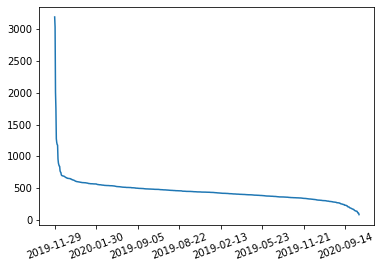

In [70]:
train_popular.t_dat.value_counts().plot()
plt.xticks(rotation=20)
plt.show()

### Recent Popular

In [73]:
from datetime import timedelta

In [76]:
last_date = train_df.t_dat.max()
last_week = last_date - timedelta(days=7)
last_month = last_date - timedelta(days=30)
last_3month = last_date - timedelta(days=30*3)

In [78]:
transaction_matrix_recent_week = train_df[train_df.t_dat >= last_week].groupby(["customer_id", "article_id"]).price.agg(["size", "mean"])
transaction_matrix_recent_month = train_df[train_df.t_dat >= last_month].groupby(["customer_id", "article_id"]).price.agg(["size", "mean"])
transaction_matrix_recent_3month = train_df[train_df.t_dat >= last_3month].groupby(["customer_id", "article_id"]).price.agg(["size", "mean"])

In [136]:
%%time
popularity_simple = transaction_matrix_recent_week.groupby("article_id")["size"].sum()
popularity_user_count = transaction_matrix_recent_week.groupby("article_id").size()
popularity_price = transaction_matrix_recent_week.groupby("article_id").apply(lambda g: (g["mean"] * g["size"]).sum()) ## bad code

CPU times: user 3.39 s, sys: 110 ms, total: 3.5 s
Wall time: 3.41 s


In [137]:
popularity_simple_list = popularity_simple.nlargest(12).index.tolist()
popularity_simple_user_list = popularity_user_count.nlargest(12).index.tolist()

In [138]:
articles.loc[popularity_simple_list]

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,,,,,,,,,,,,
924243001,924243,Ohlsson,252,Sweater,Garment Upper body,1010016,Solid,13,Beige,1,Dusty Light,1,Mole,1626,Knitwear,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1003,Knitwear,Relaxed-fit sweater vest in a soft rib knit co...
924243002,924243,Ohlsson,252,Sweater,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1626,Knitwear,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1003,Knitwear,Relaxed-fit sweater vest in a soft rib knit co...
923758001,923758,Vanessa,-1,Unknown,Unknown,1010016,Solid,10,White,3,Light,9,White,1522,Blouse,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1010,Blouses,"Wide shirt in a cotton weave with a collar, bu..."
918522001,918522,Jackie cable vest,252,Sweater,Garment Upper body,1010016,Solid,11,Off White,3,Light,9,White,1626,Knitwear,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1003,Knitwear,V-neck slipover in a soft cable knit with ribb...
909370001,909370,FF PI Haley dress,265,Dress,Garment Full body,1010022,Jacquard,11,Off White,1,Dusty Light,9,White,3090,Campaigns,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1023,Special Offers,"Short, A-line dress in a jacquard weave made f..."
866731001,866731,LANA seamless HW tigths,273,Leggings/Tights,Garment Lower body,1010016,Solid,9,Black,4,Dark,5,Black,8310,Ladies Sport Bottoms,S,Sport,26,Sport,5,Ladies H&M Sport,1005,Jersey Fancy,Ankle-length sports tights in fast-drying func...
751471001,751471,Pluto RW slacks (1),272,Trousers,Garment Lower body,1010016,Solid,9,Black,4,Dark,5,Black,1722,Trouser,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1009,Trousers,Ankle-length cigarette trousers in a stretch w...
915529003,915529,Liliana,252,Sweater,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1626,Knitwear,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1003,Knitwear,"Jumper in a soft, fine knit containing some wo..."
915529005,915529,Liliana,252,Sweater,Garment Upper body,1010016,Solid,13,Beige,1,Dusty Light,1,Mole,1626,Knitwear,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1003,Knitwear,"Jumper in a soft, fine knit containing some wo..."


In [139]:
popularity_simple_str = " ".join([str(i).zfill(10) for i in popularity_simple_list])
submission_sample.assign(prediction=popularity_simple_str).to_csv("./submissions/submission_simple_popularity_recent_week.csv", index=False)

popularity_simple_user_str = " ".join([str(i) for i in popularity_simple_user_list])
submission_sample.assign(prediction=popularity_simple_user_str).to_csv("./submissions/submission_simple_popularity_user_recent_week.csv", index=False)

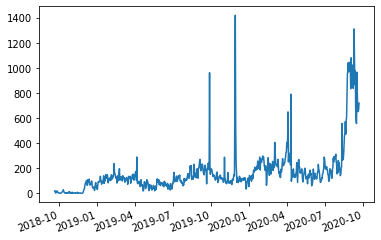

In [106]:
train_popular = train_df[train_df.article_id.isin(popularity_simple_list)]
train_popular.t_dat.value_counts().plot()
plt.xticks(rotation=20)
plt.show()

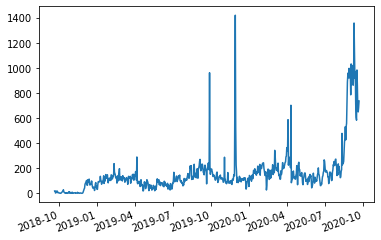

In [107]:
train_popular = train_df[train_df.article_id.isin(popularity_simple_user_list)]
train_popular.t_dat.value_counts().plot()
plt.xticks(rotation=20)
plt.show()

### train test split test

In [112]:
train_train = train_df[train_df.t_dat < last_week]
train_test = train_df[train_df.t_dat >= last_week]

In [115]:
last_week_train = last_week - timedelta(days=7)
train_train_recent_popular = train_train.loc[train_train.t_dat >= last_week_train, "article_id"].value_counts().nlargest(12)

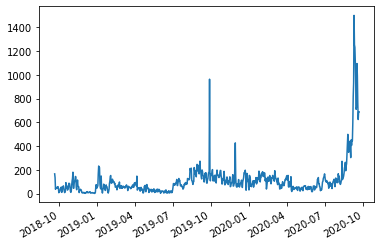

In [125]:
train_df[train_df.article_id.isin(train_train_recent_popular.index)].t_dat.value_counts().plot()

In [129]:
train_test.article_id.isin(train_train_recent_popular.index).sum(), train_test.article_id.isin(train_train_recent_popular.index).mean()


(6293, 0.023625565016293492)